In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from FlagRepp import FlagRepp
from FlagRep import FlagRep


In [2]:
def chordal_distance(X, Y, Bs_x, Bs_y):

    k = len(Bs_x)

    dist = 0

    for i in range(k):
        id_x = Bs_x[i]
        id_y = Bs_y[i]
        Xi = X[:,id_x]
        Yi = Y[:,id_y]
        mm = np.min([len(Bs_x[i]), len(Bs_y[i])])
        sin_sq = mm - np.trace(Xi.T @ Yi @ Yi.T @ Xi)
        if np.isclose(sin_sq,0):
            sin_sq = 0
        elif sin_sq < 0:
            print('sine squared less than 0')
            print(sin_sq)
            sin_sq = 0
        dist += sin_sq

    return np.sqrt(dist)


def relative_log_mse(D_rec, D_true):
    return 10*np.log10(np.linalg.norm(D_rec - D_true, 'fro')**2/(np.linalg.norm(D_true, 'fro')**2))

def MSE(D_rec, D_true, p):
    return np.sum(np.linalg.norm(D_rec- D_true, axis = 1)**2)/p 

def compute_noise_fraction(noise_exp):
    return .001*noise_exp#10**(-noise_exp)

def compute_outlier_prop(noise_exp):
    return .05*noise_exp

def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs

def generate_data_noise(noise_fraction, noise_dist, n, col_ids, ms):

    fl_ids = np.cumsum(ms)
    n_k = fl_ids[-1]

    # true flag
    X_true = np.linalg.qr(np.random.normal(size = (n,n_k)))[0][:,:n_k]

    p = np.sum(col_ids)
    
    D_true = np.hstack([X_true[:,:fl_ids[i]] @ np.random.normal(size = (fl_ids[i],col_ids[i])) for i in range(len(col_ids))])
 

    if noise_dist == 'Normal':
        noise = np.random.normal(scale = noise_fraction, size = (n,p))
    elif noise_dist == 'Exponential':
        noise = np.random.exponential(scale = noise_fraction, size = (n,p))
    elif noise_dist == 'Uniform':
        noise = noise_fraction*np.random.uniform(size = (n,p))
    
    D = D_true + noise

    snr = 10*np.log10(np.linalg.trace(D_true@D_true.T)/np.linalg.trace(noise@noise.T))

    return D, D_true, X_true, snr

def generate_data_outliers(prop_outliers, n, col_ids, ms, verbose = 0):

    #flag type with a 0 in front
    fl_ids = np.cumsum(ms)
    n_k = fl_ids[-1]

    # true flag
    X_true = np.linalg.qr(np.random.normal(size = (n,n_k)))[0][:,:n_k]

    p = np.sum(col_ids)
    n_outliers = int(np.floor(prop_outliers*p))
    outlier_subspaces = np.random.randint(len(ms), size = n_outliers)


    D = []
    inlier_ids = []
    outlier_ids = []
    jj=0
    for i in range(len(ms)):
        pi = col_ids[i]
        # get flag and dimension
        Xi = X_true[:,:fl_ids[i]]

        n_outliers_i = len(np.where(outlier_subspaces == i)[0])
        n_inliers_i = pi - n_outliers_i

        Bi = []
        for _ in range(n_inliers_i):
            Bi.append(Xi @ np.random.normal(size = (fl_ids[i],1)))
            inlier_ids.append(jj)
            jj+=1
        for _ in range(n_outliers_i):
            Bi.append((np.eye(n) - X_true @ X_true.T) @ np.random.normal(size = (n,1)))
            outlier_ids.append(jj)
            jj+=1
        
        Bi = np.hstack(Bi)
    
        D.append(Bi)
    
    D = np.hstack(D)

    return D, X_true, np.array(inlier_ids), np.array(outlier_ids)





    #     if noise_type == 'X':
    #         rand_mat = np.random.randn(rows, rank)
    #         outlier_X =  np.linalg.qr(outlierProjMat @ rand_mat)[0][:,:rank]
    #         outlierProjMat = np.eye(rows)- outlier_X @ outlier_X.T
    #         for _ in range(n_outliers):
    #             random_matrix.append(outlier_X @ np.random.normal(size = (rank,1)))
    #             outlier_ids.append(jj)
    #             jj+=1

In [3]:

n_trials = 100
n = 10
col_ids = [20,20]
p = np.sum(col_ids)
Aset = [np.arange(col_ids[0]),np.arange(p)]
fl_type = [2,4]
hidden_ms = [2,2]
noise_exps = range(0,1000,100)
distributions = ['Normal', 'Exponential', 'Uniform']

linestyles = ['solid', 'dashed', 'dotted']


Bs = make_Bs(fl_type)

In [4]:

results = pd.DataFrame(columns = ['Method','Chordal Distance', 'Noise', 'Noise Dist',  'LRSE', 'SNR (dB)'])


for noise_dist in distributions:
    for seed_num in range(n_trials):
        for noise_exp in noise_exps:
            np.random.seed(seed_num)
            
            noise_fraction = compute_noise_fraction(noise_exp) 
            
            D, D_true, hidden_X, snr = generate_data_noise(noise_fraction, noise_dist, n, col_ids, hidden_ms)#, noise_type = noise_type)

            # FlagRep
            my_flag_rep = FlagRepp(Aset = Aset, flag_type=fl_type, solver = 'svd')
            X_flagrep, R_flagrep = my_flag_rep.fit_transform(D)
            rec_flagrep = my_flag_rep.inverse_transform(X_flagrep, R_flagrep)

            cdist_flagrep = chordal_distance(hidden_X, X_flagrep, Bs, Bs)
            # mse_flagrep = np.sum(np.linalg.norm(rec_flagrep- D_true, axis = 1)**2)/p 
            # mse_flagrep = 10*np.log10(mse_flagrep/(np.trace(D_true.T @ D_true)/p))
            mse_flagrep = relative_log_mse(rec_flagrep,D_true)

            row = pd.DataFrame(columns = results.columns,
                                data = [['FlagRep',cdist_flagrep, noise_fraction, noise_dist,  mse_flagrep, snr]])
            results = pd.concat([results,row])

            # Robust FlagRep
            my_rflag_rep = FlagRepp(Aset = Aset, flag_type=fl_type, solver = 'irls svd')
            X_rflagrep, R_rflagrep = my_rflag_rep.fit_transform(D)
            rec_rflagrep = my_rflag_rep.inverse_transform(X_rflagrep, R_rflagrep)

            cdist_rflagrep = chordal_distance(hidden_X, X_rflagrep, Bs, Bs)
            # mse_rflagrep = np.sum(np.linalg.norm(rec_rflagrep- D_true, axis = 1)**2)/p 
            # mse_rflagrep = 10*np.log10(mse_rflagrep/(np.trace(D_true.T @ D_true)/p))
            mse_rflagrep = relative_log_mse(rec_rflagrep,D_true)

            row = pd.DataFrame(columns = results.columns,
                                data = [['Robust FlagRep',cdist_rflagrep, noise_fraction, noise_dist, mse_rflagrep, snr]])
            results = pd.concat([results,row])

            # SVD
            X_svd = np.linalg.svd(D)[0][:,:fl_type[-1]]

            cdist_svd = chordal_distance(hidden_X, X_svd, Bs, Bs)
            rec_svd = X_svd @ X_svd.T @ D
            # mse_svd = np.sum(np.linalg.norm(X_svd @ X_svd.T @ D - D_true, axis = 1)**2)/p 
            # mse_svd = 10*np.log10(mse_svd/(np.trace(D_true.T @ D_true)/p))
            mse_svd = relative_log_mse(rec_svd,D_true)
            

            row = pd.DataFrame(columns = results.columns,
                                data = [['SVD',cdist_svd, noise_fraction, noise_dist, mse_svd, snr]])
            results = pd.concat([results,row])





/tmp/ipykernel_381315/4262085692.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  snr = 10*np.log10(np.linalg.trace(D_true@D_true.T)/np.linalg.trace(noise@noise.T))
/tmp/ipykernel_381315/3138639590.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,row])


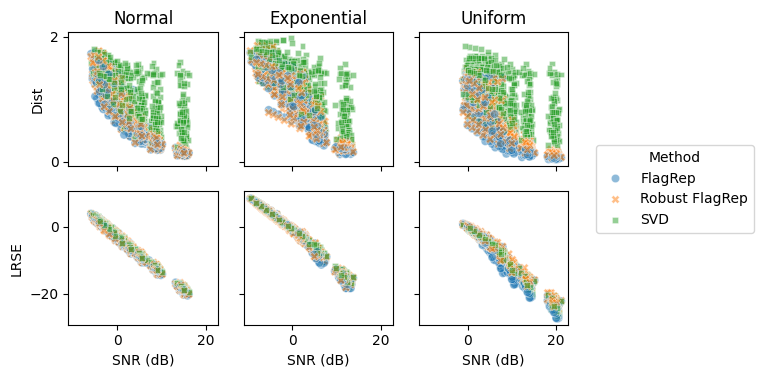

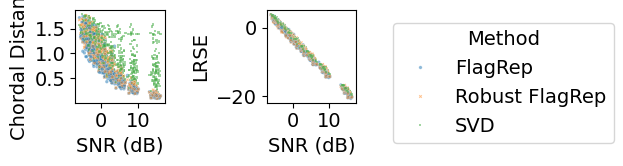

In [5]:
fig, ax = plt.subplots(2,3, figsize = (6,4), sharey = 'row', sharex = True)
for i, noise_dist in enumerate(distributions):
    
    idx = (results['Noise Dist'] == noise_dist) &\
          (results['Noise'] > 0)
    sns.scatterplot(results[idx], x = 'SNR (dB)', y = 'Chordal Distance', hue = 'Method', ax = ax[0,i], style = 'Method', alpha = .5)
    ax[0,0].set_ylabel('Dist')
    ax[0,i].set_title(noise_dist)
    sns.scatterplot(results[idx], x = 'SNR (dB)', y = 'LRSE', hue = 'Method', ax = ax[1,i], style = 'Method', alpha = .5)

for a in ax.flat:
    a.legend_.remove()
handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Method")
plt.rcParams.update({'font.size': 14})

plt.tight_layout()
# plt.savefig(f'../results/noise.pdf', bbox_inches = 'tight')



fig, ax = plt.subplots(1,2, figsize = (4,2))
idx = (results['Noise Dist'] == 'Normal') &\
          (results['Noise'] > 0)
sns.scatterplot(results[idx], x = 'SNR (dB)', y = 'Chordal Distance', hue = 'Method', ax = ax[0], style = 'Method', s = 6, alpha = .5)
sns.scatterplot(results[idx], x = 'SNR (dB)', y = 'LRSE', hue = 'Method', ax = ax[1], style = 'Method', s = 6, alpha = .5)


for a in ax.flat:
    a.legend_.remove()
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Method")
plt.rcParams.update({'font.size': 18})

plt.tight_layout()
# plt.savefig(f'../results/normal_noise.pdf', bbox_inches = 'tight')

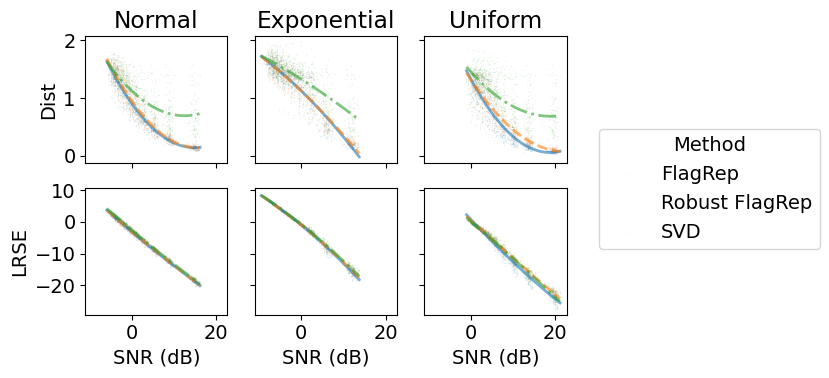

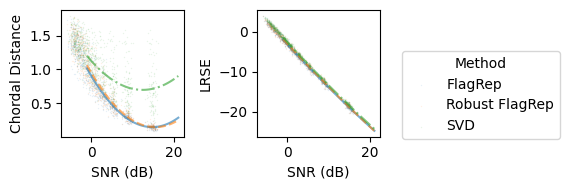

In [6]:
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 14})

# Define a quadratic function for non-linear fitting
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

# Define a list of line styles to cycle through
line_styles = ['-', '--', '-.', ':']

# Create the subplots
fig, ax = plt.subplots(2, 3, figsize=(6, 4), sharey='row', sharex=True)

for i, noise_dist in enumerate(distributions):
    idx = (results['Noise Dist'] == noise_dist) & (results['Noise'] > 0)
    
    # Non-linear line of best fit for 'Chordal Distance' by 'SNR (dB)'
    for j, method in enumerate(results['Method'].unique()):
        method_idx = idx & (results['Method'] == method)
        subset = results[method_idx]
        
        # Perform a quadratic curve fit
        popt, _ = curve_fit(quadratic, subset['SNR (dB)'], subset['Chordal Distance'])
        x_vals = np.linspace(subset['SNR (dB)'].min(), subset['SNR (dB)'].max(), 100)
        y_vals = quadratic(x_vals, *popt)
        
        # # Plot the non-linear line with scatter points
        sns.scatterplot(
            data=subset, x='SNR (dB)', y='Chordal Distance', 
            ax=ax[0, i], label=method, s=1, alpha=0.1
        )
        ax[0, i].plot(x_vals, y_vals, linestyle=line_styles[j % len(line_styles)], alpha=0.6, lw = 2)
        
    ax[0, 0].set_ylabel('Dist')
    ax[0, i].set_title(noise_dist)
    
    # Non-linear line of best fit for 'LRSE' by 'SNR (dB)'
    for j, method in enumerate(results['Method'].unique()):
        method_idx = idx & (results['Method'] == method)
        subset = results[method_idx]
        
        # Perform a quadratic curve fit
        popt, _ = curve_fit(quadratic, subset['SNR (dB)'], subset['LRSE'])
        y_vals = quadratic(x_vals, *popt)
        
        # Plot the non-linear line with scatter points
        sns.scatterplot(
            data=subset, x='SNR (dB)', y='LRSE', 
            ax=ax[1, i], label=method, s=1, alpha=0.1
        )
        ax[1, i].plot(x_vals, y_vals, linestyle=line_styles[j % len(line_styles)], alpha=0.6, lw = 2)

# Remove individual legends and add a combined legend
for a in ax.flat:
    if a.get_legend():
        a.get_legend().remove()
handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Method")

plt.tight_layout()
plt.savefig(f'../results/noise.pdf', bbox_inches = 'tight')

plt.rcParams.update({'font.size': 10})

# Separate figure for 'Normal' noise distribution
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
idx = (results['Noise Dist'] == 'Normal') & (results['Noise'] > 0)

# Non-linear fit for 'Chordal Distance' and 'LRSE'
for j, method in enumerate(results['Method'].unique()):
    method_idx = idx & (results['Method'] == method)
    subset = results[method_idx]
    
    # Non-linear fit for 'Chordal Distance'
    popt, _ = curve_fit(quadratic, subset['SNR (dB)'], subset['Chordal Distance'])
    y_vals = quadratic(x_vals, *popt)
    sns.scatterplot(
        data=subset, x='SNR (dB)', y='Chordal Distance', 
        ax=ax[0], label=method, s=1, alpha=0.1
    )
    ax[0].plot(x_vals, y_vals, linestyle=line_styles[j % len(line_styles)], alpha=0.6)
    
    # Non-linear fit for 'LRSE'
    popt, _ = curve_fit(quadratic, subset['SNR (dB)'], subset['LRSE'])
    y_vals = quadratic(x_vals, *popt)
    sns.scatterplot(
        data=subset, x='SNR (dB)', y='LRSE', 
        ax=ax[1], label=method, s=1, alpha=0.1
    )
    ax[1].plot(x_vals, y_vals, linestyle=line_styles[j % len(line_styles)], alpha=0.6)

for a in ax.flat:
    if a.get_legend():
        a.get_legend().remove()
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Method")


plt.tight_layout()
plt.savefig(f'../results/normal_noise.pdf', bbox_inches = 'tight')


/tmp/ipykernel_381315/881443109.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,row])


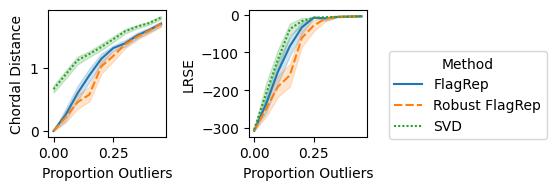

In [7]:
n = 10
col_ids = [20,20]

p = np.sum(col_ids)
Aset = [np.arange(col_ids[0]),np.arange(p)]

outlier_exps = range(0,10)

Bs = make_Bs(fl_type)


results = pd.DataFrame(columns = ['Method','Chordal Distance', 'Proportion Outliers', 'LRSE'])
for seed_num in range(n_trials):
    for outlier_exp in outlier_exps:
        np.random.seed(seed_num)
        prop_outliers = compute_outlier_prop(outlier_exp)
        
        D, hidden_Xs, inlier_ids, outlier_ids = generate_data_outliers(prop_outliers, n, col_ids, hidden_ms)
        D_inliers = D[:,inlier_ids]
        n_inliers = len(inlier_ids)
        


        my_flag_rep = FlagRepp(Aset = Aset, flag_type=fl_type)
        X_flagrep, R_flagrep = my_flag_rep.fit_transform(D)
        D_flagrep = X_flagrep @ X_flagrep.T @ D
        # D_flagrep = my_flag_rep.inverse_transform(X_flagrep, R_flagrep)
        D_flagrep_inliers = D_flagrep[:,inlier_ids]
        cdist_flagrep = chordal_distance(hidden_Xs,X_flagrep,Bs,Bs)
        # mse_flagrep = np.sum(np.linalg.norm(D_flagrep_inliers - D_inliers, axis = 1)**2)/n_inliers
        # mse_flagrep = 10*np.log10(mse_flagrep/(np.trace(D_inliers.T @ D_inliers)/n_inliers))
        mse_flagrep = relative_log_mse(D_flagrep_inliers, D_inliers)


        row = pd.DataFrame(columns = results.columns,
                            data = [['FlagRep',cdist_flagrep, prop_outliers, mse_flagrep]])
        results = pd.concat([results,row])


        my_flag_rep = FlagRepp(Aset = Aset, flag_type=fl_type, solver = 'irls svd')
        X_rflagrep, R_rflagrep = my_flag_rep.fit_transform(D)
        D_rflagrep = X_rflagrep @ X_rflagrep.T @ D
        # D_rflagrep = my_flag_rep.inverse_transform(X_rflagrep, R_rflagrep)
        D_rflagrep_inliers = D_rflagrep[:,inlier_ids]
        cdist_rflagrep = chordal_distance(hidden_Xs, X_rflagrep,Bs,Bs)
        # mse_rflagrep = np.sum(np.linalg.norm( D_rflagrep_inliers - D_inliers, axis = 1)**2)/n_inliers
        # mse_rflagrep = 10*np.log10(mse_rflagrep/(np.trace(D_inliers.T @ D_inliers)/n_inliers))
        mse_rflagrep = relative_log_mse(D_rflagrep_inliers, D_inliers)
        row = pd.DataFrame(columns = results.columns,
                            data = [['Robust FlagRep',cdist_rflagrep, prop_outliers, mse_rflagrep]])
        results = pd.concat([results,row])

        X_svd = np.linalg.svd(D)[0][:,:fl_type[-1]]
        cdist_svd = chordal_distance(hidden_Xs, X_svd,Bs,Bs)
        D_svd_inliers = X_svd @ X_svd.T @ D_inliers
        # mse_svd = np.sum(np.linalg.norm(X_svd @ X_svd.T @ D_inliers - D_inliers, axis = 1)**2)/n_inliers
        # mse_svd = 10*np.log10(mse_svd/(np.trace(D_inliers.T @ D_inliers)/n_inliers))
        mse_svd= relative_log_mse(D_svd_inliers, D_inliers)
        row = pd.DataFrame(columns = results.columns,
                            data = [['SVD',cdist_svd, prop_outliers, mse_svd]])
        results = pd.concat([results,row])

fig, ax = plt.subplots(1,2,  figsize = (4,2))

sns.lineplot(results, x = 'Proportion Outliers', y = 'Chordal Distance', hue = 'Method', ax = ax[0], style = 'Method')
sns.lineplot(results, x = 'Proportion Outliers', y = 'LRSE', hue = 'Method', ax = ax[1], style = 'Method')


for a in ax.flat:
    a.legend_.remove()
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Method")

plt.tight_layout()
plt.savefig(f'../results/outliers.pdf', bbox_inches = 'tight')


